[source](https://github.com/ai2ys/ml-zoomcamp/blob/main/leaderboard_visualization.ipynb) notebook by [Sylvia Schmitt](https://twitter.com/ai2ys)

Instruction for running this leaderboard notebook with the provided :whale: Dockerfile and JupyterLab.

1. Run the command **`docker compose run --rm --service-ports mlzoomcamp`** from the shell of the project base directory
    ```bash
    $ docker compose run --rm --service-ports mlzoomcamp
    ```
    The JupyterLab port defaults to `8888`. If required adapt the JupyterLab port can be changed at container startup by running the following command instead
    ```bash
    $ PORT_JNB=<port> docker compose run --rm --service-ports mlzoomcamp
    ```

2. After you see the shell of the container **`root@mlzoomcamp:/workspace#`** you can easily start JupyterLab using the alias **`jlab`** in the shell of the container. It will use the provided port from container startup.
    ```bash
    `root@mlzoomcamp:/workspace# jlab
    
    ```


# Plotting histogram of total score

Check your placement for total scores.

In [2]:
# !pip install lxml ipywidgets
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !micromamba install xlrd openpyxl

***:information_source: Restart kernel after executing the cell above for installing missing libraries.***

In [3]:
positions = {}
scores = {}
import glob

# Define the file extension
extension = '*.xlsx'

# Extract the list of files with the extension
file_list = glob.glob(extension)

# Print the list of files
print(file_list)

['leaderboard_wk1.xlsx', 'leaderboard_wk2.xlsx', 'leaderboard_wk3.xlsx', 'leaderboard_wk4.xlsx', 'leaderboard_wk5.xlsx', 'leaderboard_wk6.xlsx', 'leaderboard_wk7.xlsx']


In [4]:
from hashlib import sha1
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from typing import Tuple
from IPython.display import display, clear_output
import os

email = 'ellacharmed@gmail.com'
my_scores = pd.DataFrame(columns=['task', 'n_submissions', 'position', 'score'])

def compute_hash():
    return sha1(email.lower().encode('utf-8')).hexdigest()

def read_leaderboard_from_excel_spreadsheet(
        url:str='leaderboard_wk7.xlsx'
    )->pd.DataFrame:
    list_df = pd.read_excel(url, index_col=0)

    return list_df

def read_leaderboard_from_google_spreadsheet(
        url:str='https://docs.google.com/spreadsheets/d/e/2PACX-1vSNK_yGtELX1RJK1SSRl4xiUbD0XZMYS6uwHnybc7Mql-WMnMgO7hHSu59w-1cE7FeFZjkopbh684UE/pubhtml#'
    )->pd.DataFrame:
    list_df = pd.read_html(url, header=1, index_col=0)
    for df in list_df[1:]:
        df.drop(index=np.NaN, inplace=True)
        df.reset_index(drop=True, inplace=True)
    df_leaderboard = list_df[-1]

    return df_leaderboard

def get_your_score_and_position(
        df_leaderboard:pd.DataFrame,
        email_hash:str,
    )->Tuple[int, int]:
    indices = df_leaderboard.email==email_hash
    # print(indices.any())
    if indices.any():
        position = df_leaderboard.loc[indices].total.index.to_list()[0]
        total_score = df_leaderboard.loc[indices].total.values[0]
        found = True
    else:
        print('Your email is not found in the leaderboard')
        found = False
        position = np.nan
        total_score = np.nan
    return found, position, total_score

def collate_leaderboard_for_all_weeks() -> pd.DataFrame:
    df = pd.DataFrame()
    print(file_list)
    for file in file_list:
        print(f'reading {file} ... ')
        df = read_leaderboard_from_excel_spreadsheet(file)
        temp_df = pd.DataFrame()
        display(df.head(2))
        
        global email_hash, total_score, position, my_scores
        email_hash = compute_hash()
        solved_tasks = df.loc[:, 'email':'total'].columns[1:-1].to_list()
        
        submissions = len(df[df.iloc[:, -2] > 0])
        print(f'{submissions}')
        found, position, total_score = get_your_score_and_position(
            df,
            email_hash)
        if not found:
            result = f"Unable to find your email hash in the leaderboard:\nemail:\t'{email}'\nhash:\t'{email_hash}'"
        else:
            data = { 
                'task': solved_tasks[-1], 
                'n_submissions' : submissions, 
                'position' : position, 
                'score' : total_score
            }
            temp_df = pd.DataFrame(data=data, index=[1])
            display(temp_df)
            my_scores = pd.concat([my_scores, temp_df], ignore_index=True)
            result = f"email:\t'{email}'\nhash:\t'{email_hash}'\nposition:\t{position} (zero-based index)\ntotal score:\t{total_score}\n\nsolved tasks:\t{solved_tasks}"
            print(f'{solved_tasks[-1]}, {position =}, {total_score =}')
            display(my_scores)
            print()
    return df, result

def plot_leaderboard_histogram_syl(
        df_leaderboard:pd.DataFrame, 
        ax:plt.Axes=None,
        your_score:int=np.nan, 
        your_position:int=np.nan,
        marker='o',
        color='orange', 
        ):
    ax = df_leaderboard.total.hist(bins=200, ax=ax, cumulative=True, alpha=.7)
    ax.grid(False)

    n = len(df_leaderboard)
    ax.hlines(n-100, xmin=0, xmax=df_leaderboard.total.max(), color='black', linestyles=':', label='top 100')
    
    if your_score != np.nan:
        ax.scatter(
            x=your_score,
            y=n-your_position,
            color=color,
            marker=marker,
            label='your position'
        )
    ax.set_xlabel('total scores')
    ax.set_title('Check your placement for total scores')
    ax.grid(False)
    ax.legend()
    return ax

In [5]:
df_leaderboard = read_leaderboard_from_excel_spreadsheet()

In [6]:
df, result = collate_leaderboard_for_all_weeks()

['leaderboard_wk1.xlsx', 'leaderboard_wk2.xlsx', 'leaderboard_wk3.xlsx', 'leaderboard_wk4.xlsx', 'leaderboard_wk5.xlsx', 'leaderboard_wk6.xlsx', 'leaderboard_wk7.xlsx']
reading leaderboard_wk1.xlsx ... 


,email,hw-01,total
id,,,
1,2a56ff196285928eaa68969d3422ed963168dc38,15,15
2,3b4f201e6a1c3b2566008c66556608cb9a32e7c8,15,15


790


,task,n_submissions,position,score
1,hw-01,790,527,7


hw-01, position =527, total_score =7


,task,n_submissions,position,score
0,hw-01,790,527,7



reading leaderboard_wk2.xlsx ... 


,email,hw-01,hw-02,total
id,,,,
1,eaecbc75eeb043c71a56a47b971d3701bc0f1cca,15,14,29
2,2a56ff196285928eaa68969d3422ed963168dc38,15,14,29


558


,task,n_submissions,position,score
1,hw-02,558,203,13


hw-02, position =203, total_score =13


,task,n_submissions,position,score
0,hw-01,790,527,7
1,hw-02,558,203,13



reading leaderboard_wk3.xlsx ... 


,email,hw-01,hw-02,hw-03,total
id,,,,,
1,eaecbc75eeb043c71a56a47b971d3701bc0f1cca,15,14,14,43
2,2a56ff196285928eaa68969d3422ed963168dc38,15,14,14,43


459


,task,n_submissions,position,score
1,hw-03,459,168,19


hw-03, position =168, total_score =19


,task,n_submissions,position,score
0,hw-01,790,527,7
1,hw-02,558,203,13
2,hw-03,459,168,19



reading leaderboard_wk4.xlsx ... 


,email,hw-01,hw-02,hw-03,hw-04,total
id,,,,,,
1,eaecbc75eeb043c71a56a47b971d3701bc0f1cca,15,14,14,14,57
2,2a56ff196285928eaa68969d3422ed963168dc38,15,14,14,14,57


356


,task,n_submissions,position,score
1,hw-04,356,77,28


hw-04, position =77, total_score =28


,task,n_submissions,position,score
0,hw-01,790,527,7
1,hw-02,558,203,13
2,hw-03,459,168,19
3,hw-04,356,77,28



reading leaderboard_wk5.xlsx ... 


,email,hw-01,hw-02,hw-03,hw-04,hw-05,total
id,,,,,,,
1,2a56ff196285928eaa68969d3422ed963168dc38,15,14,14,14,14,71
2,eaecbc75eeb043c71a56a47b971d3701bc0f1cca,15,14,14,14,13,70


299


,task,n_submissions,position,score
1,hw-05,299,29,42


hw-05, position =29, total_score =42


,task,n_submissions,position,score
0,hw-01,790,527,7
1,hw-02,558,203,13
2,hw-03,459,168,19
3,hw-04,356,77,28
4,hw-05,299,29,42



reading leaderboard_wk6.xlsx ... 


,email,hw-01,hw-02,hw-03,hw-04,hw-05,hw-06,total
id,,,,,,,,
1,2a56ff196285928eaa68969d3422ed963168dc38,15,14,14,14,14,14,85
2,eaecbc75eeb043c71a56a47b971d3701bc0f1cca,15,14,14,14,13,12,82


267


,task,n_submissions,position,score
1,hw-06,267,26,55


hw-06, position =26, total_score =55


,task,n_submissions,position,score
0,hw-01,790,527,7
1,hw-02,558,203,13
2,hw-03,459,168,19
3,hw-04,356,77,28
4,hw-05,299,29,42
5,hw-06,267,26,55



reading leaderboard_wk7.xlsx ... 


,email,hw-01,hw-02,hw-03,hw-04,hw-05,hw-06,project-01,total
id,,,,,,,,,
1,2a56ff196285928eaa68969d3422ed963168dc38,15,14,14,14,14,14,40,125
2,e153f7f76cc7c65f6598ff83fc4445bb774159da,8,14,14,14,14,12,45,121


207


,task,n_submissions,position,score
1,project-01,207,13,97


project-01, position =13, total_score =97


,task,n_submissions,position,score
0,hw-01,790,527,7
1,hw-02,558,203,13
2,hw-03,459,168,19
3,hw-04,356,77,28
4,hw-05,299,29,42
5,hw-06,267,26,55
6,project-01,207,13,97


In [7]:
total_score = np.nan
position = np.nan

email_hash = compute_hash() # my email is hardcoded

In [8]:
solved_tasks = df_leaderboard.loc[:, 'email':'total'].columns[:-1].to_list()
# .columns[1:-1]

In [9]:
solved_tasks

['email', 'hw-01', 'hw-02', 'hw-03', 'hw-04', 'hw-05', 'hw-06', 'project-01']

In [10]:
text_email = widgets.Text(
    placeholder=email,
    disabled=False,
)
text_hash = widgets.Text(
    placeholder='calculated hash',
    disabled=True,
)
text_info = widgets.Textarea(
    placeholder='infos about your placement and total score',
    layout = widgets.Layout(width='800px', height='100px'),
    disabled=True,
)

In [11]:
def on_button_clicked(b):
    global email_hash, total_score, position
    email_hash = compute_hash()
    text_hash.placeholder = email_hash
    found, position, total_score = get_your_score_and_position(
        df_leaderboard,
        email_hash)
    if not found:
        text_info.value = f"Unable to find your email hash in the leaderboard:\nemail:\t'{text_email.value}'\nhash:\t'{email_hash}'"
    else:
        text_info.value = f"email:\t'{email}'\nhash:\t'{email_hash}'\nposition:\t{position} (zero-based index)\ntotal score:\t{total_score}\n\nsolved tasks:\t{solved_tasks}"

submit_button=widgets.Button(description='>> calculate hash >>',button_style='success')

submit_button.on_click(on_button_clicked)
hbox_hash_calc = widgets.HBox([text_email,submit_button, text_hash])
all_widgets = widgets.VBox([hbox_hash_calc, text_info])
display(all_widgets)

position_by_tasks = {<br>
                'hw-01': 527, <br>
                'hw-02': 203, <br>
                'hw-03': 168, <br>
                'hw-04' : 77,<br>
                'hw-05' : 29,<br>
                'hw-06' : 26,<br>
                'project-01' : 13,<br>
            }

score_by_weeks = {<br>
                'hw-01': 527, <br>
                'hw-02': 203, <br>
                'hw-03': 168, <br>
                'hw-04' : 77,<br>
                'hw-05' : 42,<br>
                'hw-06' : 55,<br>
                'project-01' : 97,<br>
            }

In [12]:
my_scores

,task,n_submissions,position,score
0,hw-01,790,527,7
1,hw-02,558,203,13
2,hw-03,459,168,19
3,hw-04,356,77,28
4,hw-05,299,29,42
5,hw-06,267,26,55
6,project-01,207,13,97


In [30]:
my_scores.iloc[-1].task

'project-01'

## Notes

From Alexey's announcement posts. Differs from above n_submissions

- week01: We had 843 submissions. 
- week02: We had 596 submissions. 
- week03: We had 517 submissions. 
- week04: We had 375 submissions. 
- week05: We had 325 submissions. 
- week06: We had 282 submissions. 
- project-01: We had 311 submissions
- week08: We had  submissions
- week09: We had  submissions
- week10: We had  submissions
- capstone-01: We had  submissions
- capstone-02: We had  submissions

In [13]:
# n_submission from hw-01 - current score
790-97

693

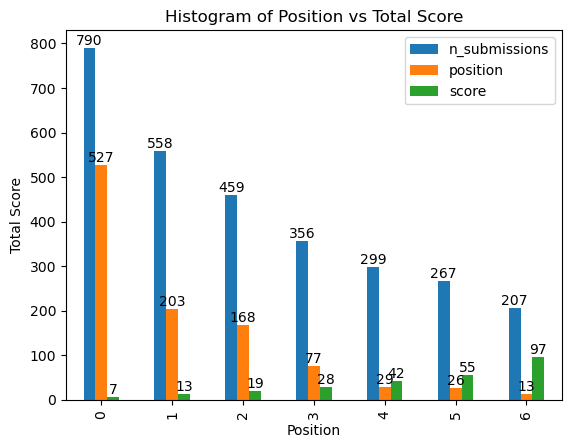

In [14]:
fig, ax = plt.subplots()
my_scores.plot(kind='bar', ax=ax)

for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.title('Histogram of Position vs Total Score')
plt.xlabel('Position')
plt.ylabel('Total Score')
plt.show()

In [15]:
# df_leaderboard.shape[0] - current position
df_leaderboard.shape[0]-13

873

In [16]:
df_leaderboard

,email,hw-01,hw-02,hw-03,hw-04,hw-05,hw-06,project-01,total
id,,,,,,,,,
1,2a56ff196285928eaa68969d3422ed963168dc38,15,14,14,14,14,14,40,125
2,e153f7f76cc7c65f6598ff83fc4445bb774159da,8,14,14,14,14,12,45,121
3,4170f8f415790fffa69a9534232ceaefc9ff82db,14,12,13,13,12,14,43,121
4,30608da641c084ad66a0cf0f901a91ad48ff360a,8,11,14,14,14,13,45,119
5,aa07bfc132bcebef6a3c97ea747453c540306a9f,8,13,13,13,13,13,43,116
...,...,...,...,...,...,...,...,...,...
882,1dd2d9013b7d61d39e321468c484466786c5f881,0,0,0,0,0,0,0,0
883,17b3ac7d8c9f8ba0bf2064e44890bcc73aea7327,0,0,0,0,0,0,0,0
884,11310b3d4763a24e4008a13e40ecad20bd47a611,0,0,0,0,0,0,0,0


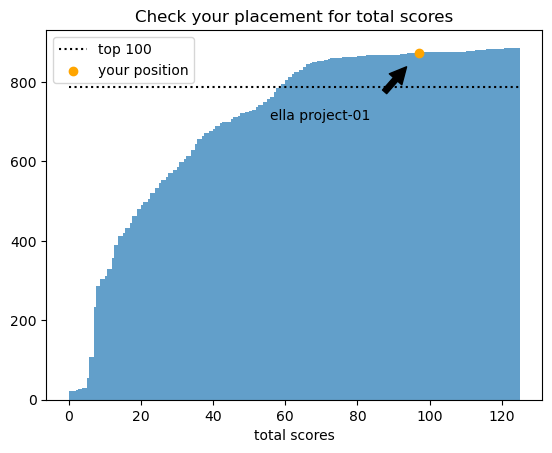

In [17]:
ax = plot_leaderboard_histogram_syl(
        df_leaderboard, 
        your_score=my_scores.iloc[-1,-1], 
        your_position=my_scores.iloc[-1,-2])

ax.annotate('ella project-01',
            xy=(97, 873), xycoords='data',
            xytext=(0.45, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.25),
            horizontalalignment='left', verticalalignment='bottom')
plt.show()


In [20]:
total_score = my_scores.iloc[-1,-1]
total_score

97

In [21]:
leaderboard_position = my_scores.iloc[-1,-2]
leaderboard_position

13

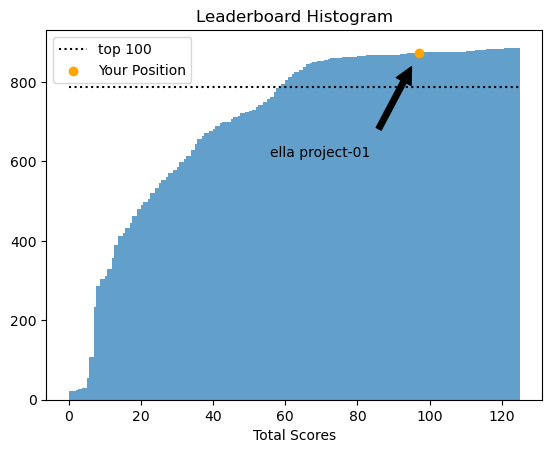

In [32]:
# total_score = my_scores.iloc[-1,-1]
# leaderboard_position = my_scores.iloc[-1,-2]

def plot_leaderboard_histogram(df_leaderboard: pd.DataFrame, total_score: int = None, leaderboard_position: int = None):
    # Plotting the histogram
    ax = df_leaderboard.total.hist(bins=200, cumulative=True, alpha=.7)
    ax.grid(False)
    
    n = len(df_leaderboard)
    ax.hlines(n-100, xmin=0, xmax=df_leaderboard.total.max(), color='black', linestyles=':', label='top 100')
    
    if total_score is not None and leaderboard_position is not None:
        # Plotting the user's position
        ax.scatter(x=total_score, y=n - leaderboard_position, color='orange', marker='o', label='Your Position')

    ax.annotate('ella '+my_scores.iloc[-1].task,
            xy=(total_score, n - leaderboard_position), xycoords='data',
            xytext=(0.45, 0.65), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='left', verticalalignment='bottom')
    
    ax.set_xlabel('Total Scores')
    ax.set_title('Leaderboard Histogram')
    ax.legend()
    
    plt.show()

# plot leaderboard
plot_leaderboard_histogram(df_leaderboard, total_score, leaderboard_position)